Resourses
https://github.com/haoyye/End2End_GAN/tree/master
https://github.com/matusstas/cGAN/blob/main/cgan.ipynb

 Check GPU

In [387]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Mar 27 08:48:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX230         WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   47C    P8              N/A / ERR! |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Import dependencies

In [388]:
# wandb (weights and biases) -> tracking tool
!pip install -q wandb 

In [389]:
import numpy as np
import tensorflow as tf
import pandas as pd

#To datasets -> import tensorflow_datasets as tfds

# For models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Embedding, Input, Concatenate #, Conv2DTranspose

# Callbacks
# Visit this -> https://kvirajdatt.medium.com/essential-tensorflow-and-keras-callbacks-for-your-neural-networks-54539244db39#:~:text=Some%20advantages%20of%20using%20these,of%20epochs%20for%20your%20training
from tensorflow.keras.callbacks import Callback

# For streamlining ML workflow
import wandb
from wandb.keras import WandbCallback

# For model memory
from tensorflow.keras import backend as k
import humanize

# For visualisation
from matplotlib import pyplot as plt


Set data

In [390]:
n = 2
k = 2

Input_Shape = (2*n,1)  # Shape of the conditional input (this is normalized)
noise_std = 1           # Standerd deviation for the noise to be added to the conditional values for better generalization (change this)

"""---- Import dataset here ----"""

"""--------"""

# latent_vector_dim = 100 # For the Generator input
batch_size = 320

#n_batches = len(data//batch_size)

N_epochs = 1

# Name of the project for Weights and Biases platform
WB_project = "CGAN"

# Entity (login) for Weights and Biases platform
WB_entity = "matusstas" # shearch this

# Here for every 320 messages, 1/4 of them (80) are pilot symbols . every message has 2*n values (n complex values)
num_frames = 10000


In [391]:
# Getting real data

from scipy.io import loadmat

def complex_data_to_real_seq(a):
    b= np.concatenate((np.reshape(np.real(a),(-1,1)),np.reshape(np.imag(a),(-1,1))),axis=1)
    return np.reshape(b,(-1,1))

data_x = loadmat(r"D:\Engineering\ENTC\Final Year Project\Project\Deep-Learning-for-End-to-End-Over-the-Air-Communications\Lathika\dataset\actual_phshdata_2.mat")
print(data_x.keys())
x=data_x["actual_phshdata"]
data_y = loadmat(r"D:\Engineering\ENTC\Final Year Project\Project\Deep-Learning-for-End-to-End-Over-the-Air-Communications\Lathika\dataset\received_iq_2.mat")
print(data_y.keys())
y=data_y["received_iq"]

df=np.concatenate((complex_data_to_real_seq(x),complex_data_to_real_seq(y)),axis=1)
df=pd.DataFrame(df)

print(df.shape)
print(x[-1],y[-1],df[3344014:3344016])

dict_keys(['__header__', '__version__', '__globals__', 'actual_phshdata'])
dict_keys(['__header__', '__version__', '__globals__', 'received_iq'])
(3344016, 2)
[-1.08789289-0.59154558j] [-1.17907359-0.31164175j]                 0         1
3344014 -1.087893 -1.179074
3344015 -0.591546 -0.311642


In [392]:
# Re defining the number of frames according to the given data set
num_frames = df.shape[0]//(batch_size*2*n)

# Assuming batch size of 320 
i_val = int(num_frames*batch_size/4*2*n)
x = np.zeros(i_val*3)
y = np.zeros(i_val*3)
pilot_x = np.zeros(i_val)
pilot_y = np.zeros(i_val)

i_val= int(batch_size/4*2*n)
x_hat = df.iloc[:,0]
y_hat = df.iloc[:,1]
for i in range(num_frames):
    
    left_i_xy = 3*i_val*i
    right_i_xy = left_i_xy + 3*i_val
    left_i_p = i*i_val
    right_i_p = left_i_p + i_val

    x[left_i_xy:right_i_xy] = x_hat[0:3*i_val]
    pilot_x[left_i_p:right_i_p] = x_hat[3*i_val:batch_size*2*n]

    y[left_i_xy:right_i_xy] = y_hat[0:3*i_val]
    pilot_y[left_i_p:right_i_p] = y_hat[3*i_val:batch_size*2*n]


In [393]:
print(x.shape)
print(y.shape)
print(pilot_x.shape)
print(pilot_y.shape)
print(type(x))

(2507520,)
(2507520,)
(835840,)
(835840,)
<class 'numpy.ndarray'>


Calculate channel function

In [394]:

def real_to_complex(a):
    a= np.reshape(a,(len(a)//2,2))
    a= np.vectorize(complex)(np.transpose(a[:,0]),np.transpose(a[:,1]))
    return a

# We input x & y two real arrays. ex:- x = [1,2,3,4] y = [5,6,7,8]
# Then convert them into complex and calculate the channel coefficient 
# x-> [1+2j,3+4j], y-> [5+6j,7+8j]
# h-> [a+bj] -> [a,b] returns as two real values
def get_channel_coeff(x,y):
    h = np.matmul(real_to_complex(x).conj().T,real_to_complex(y))/np.matmul(real_to_complex(x).conj().T,real_to_complex(x))
    return np.array([np.real(h),np.imag(h)])

# there will be different h for each frame. batch_size*3/4 of same h values will be there corresponding to the x and y values
h = np.ones((int(num_frames*batch_size*3/4),2))

for i in range(num_frames):
    u = int(i*batch_size/4*n*2)
    stp = int(batch_size/4)
    temp_x = pilot_x[u:u+stp*2*n]
    temp_y = pilot_y[u:u+stp*2*n]
    h_temp = get_channel_coeff(temp_x,temp_y)
    h_temp = np.reshape(np.tile(h_temp,stp*3),(stp*3,2))
    h[i*stp*3:(i+1)*stp*3]=h_temp


In [395]:
# Reshaping data set
x = np.reshape(x,(-1,2*n))   # np.reshape(x,(-1,batch_size,2*n))
y = np.reshape(y,(-1,2*n))
h = np.reshape(h,(-1,2))
print(x.shape,y.shape,h.shape)
dataset = np.concatenate((x,y,h),axis=1)

(626880, 4) (626880, 4) (626880, 2)


## Build Models


Helper function to calculate model memory usage

In [396]:
def get_model_usage(model):
    """
    Get memory usage of the model with chosen batch size 
    
    modified function from this link: https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model
    """
    count_shapes_mem = 0
    count_internal_model_mem = 0

    for layer in model.layers:
        layer_type = layer.__class__.__name__
        
        if layer_type == "Model":
            count_internal_model_mem += get_model_usage(batch_size, layer)
        
        single_layer_mem = 1
        out_shape = layer.output_shape
        out_shape = out_shape[0] if type(out_shape) is list else out_shape
    
        for shape in out_shape:
            if shape is None:
                continue
            single_layer_mem *= shape
        count_shapes_mem += single_layer_mem

    count_trainable = np.sum([K.count_params(p) for p in model.trainable_weights])
    count_non_trainable = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    # Choose correct precision of floating-point numbers
    precisions = {"float16": 2.0, "float32": 4.0, "float64": 8.0}
    number_size = precisions[K.floatx()]

    total_memory = number_size * (batch_size * count_shapes_mem + count_trainable + count_non_trainable)
    total_memory = humanize.naturalsize(total_memory + count_internal_model_mem, binary=True)
    print(f"Total memory usage with batch size of {batch_size} is: {total_memory}")

### Generator

In [397]:
def build_generator():
    input_pilot = Input(shape=(2,))
    input_x = Input(shape=(2*n,))
    inp = Concatenate()([input_x,input_pilot])
    l = Dense(128)(inp)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(128)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(128)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    output = Dense(2*n,activation = 'linear')(l)

    model = Model([input_x,input_pilot],output)
    return model

In [398]:
generator = build_generator()

Model: "model_58"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_118 (InputLayer)      [(None, 4)]                  0         []                            
                                                                                                  
 input_117 (InputLayer)      [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_58 (Concatenat  (None, 6)                    0         ['input_118[0][0]',           
 e)                                                                  'input_117[0][0]']           
                                                                                                  
 dense_232 (Dense)           (None, 128)                  896       ['concatenate_58[0][0]'

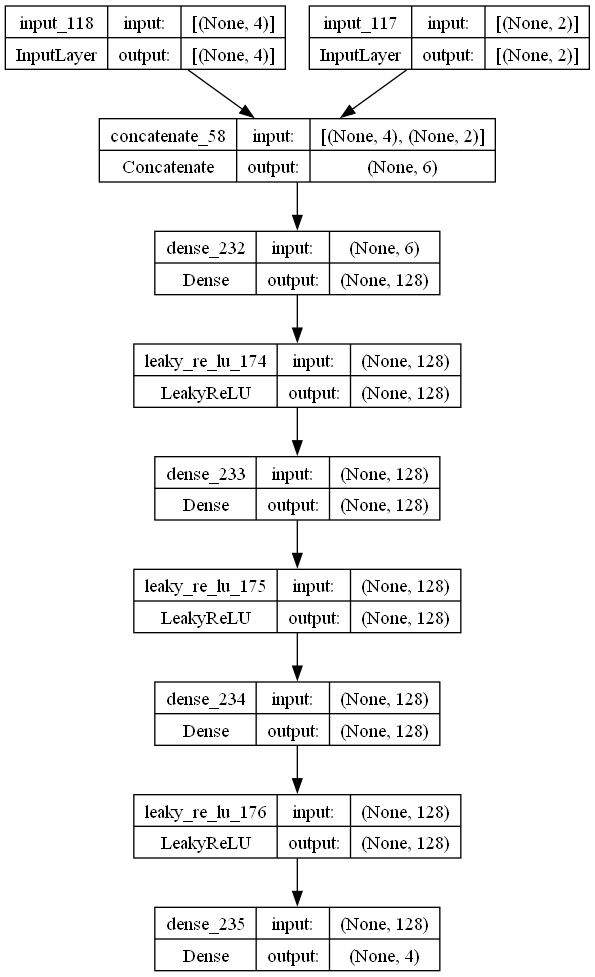

In [399]:
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True)

### Build Discreminator

In [400]:
def build_discriminator():
    input_pilot = Input(shape=(2,))
    input_x = Input(shape=(2*n,))
    inp = Concatenate()([input_x,input_pilot])
    l = Dense(32)(inp)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(32)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(32)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    output = Dense(1,activation = 'sigmoid')(l)

    model = Model([input_x,input_pilot],output)
    return model

In [401]:
discriminator = build_discriminator()

Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_120 (InputLayer)      [(None, 4)]                  0         []                            
                                                                                                  
 input_119 (InputLayer)      [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_59 (Concatenat  (None, 6)                    0         ['input_120[0][0]',           
 e)                                                                  'input_119[0][0]']           
                                                                                                  
 dense_236 (Dense)           (None, 32)                   224       ['concatenate_59[0][0]'

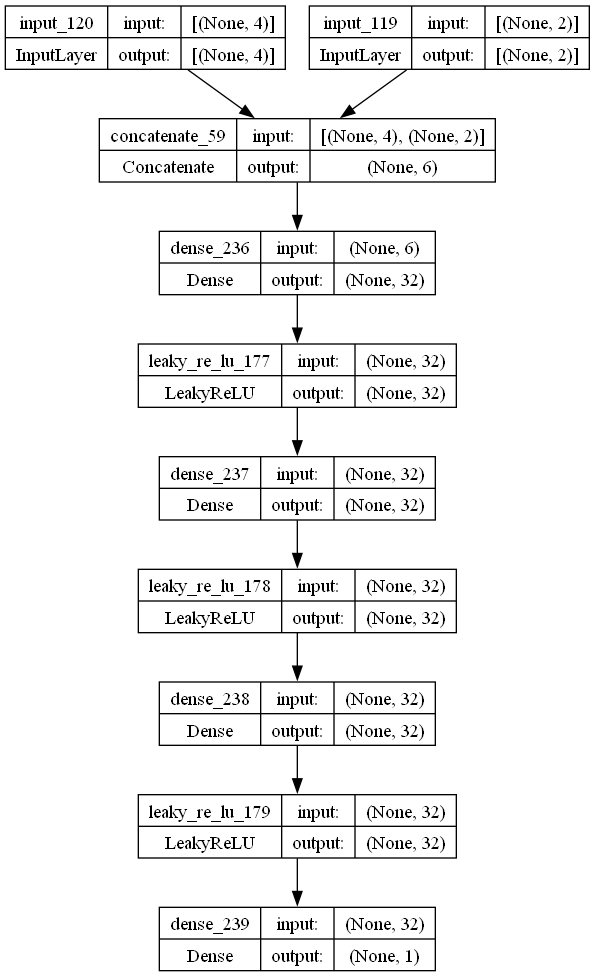

In [402]:
discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [403]:
# For GAN evaluation
# Better to have a lower FID value near 0
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # Converting tensors to numpy
    print(type(act1))
    tf.config.run_functions_eagerly(True)
    d_1 = act1.numpy()
    d_2 = act2.numpy()
    # calculate mean and covariance statistics
    mu1, sigma1 = d_1.mean(axis=0), np.cov(d_1, rowvar=False)
    mu2, sigma2 = d_2.mean(axis=0), np.cov(d_2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [404]:

# Create a tensor
tensor = tf.constant([[1, 2], [3, 4]])
tensor_ = tf.constant([[4, 5], [7, 5]])

# Convert the tensor to a NumPy array
numpy_array = tensor.numpy()

# Print the NumPy array
print(numpy_array)

print(calculate_fid(tensor,tensor_))

[[1 2]
 [3 4]]
<class 'tensorflow.python.framework.ops.EagerTensor'>
18.75


### Build CGAN -  Customize .fit

In [405]:
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#:~:text=When%20you%20need%20to%20customize,running%20your%20own%20learning%20algorithm.

class GAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, opt_g, opt_d, loss_g, loss_d, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.opt_g = opt_g
        self.opt_d = opt_d
        self.loss_g = loss_g
        self.loss_d = loss_d 

    @tf.function 
    def train_step(self, dataset):
        #batch_x -> input to generator, batch_y -> real samples for discriminator, pilots -> as conditional information
        batch_x,batch_y,pilots = dataset[:,0:2*n],dataset[:,2*n:4*n],dataset[:,4*n:4*n+2]
        # Generate samples
        symbols_generated = self.generator([batch_x, pilots], training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake symbols to the discriminator model
            yhat_real = self.discriminator([batch_y, pilots], training=True) 
            yhat_fake = self.discriminator([symbols_generated, pilots], training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes symbols
            # We train the discriminator to identify real and fake. 0 for real and 1 as fake.
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs (crucial step)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss 
            total_loss_d = self.loss_d(y_realfake, yhat_realfake)
            
        # Apply backpropagation 
        dgrad = d_tape.gradient(total_loss_d, self.discriminator.trainable_variables) 
        self.opt_d.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate symbols
            symbols_generated = self.generator([batch_x, pilots], training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator([symbols_generated, pilots], training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_loss_g = self.loss_g(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backpropagation
        ggrad = g_tape.gradient(total_loss_g, self.generator.trainable_variables)
        self.opt_g.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        # Calculate FID for GAN evaluation
        #fid = calculate_fid(symbols_generated,batch_y)
        
        return {"loss_d":total_loss_d, "loss_g":total_loss_g}#, "FID score ":fid}
     

Build monitoring callback

In [406]:
"""class ModelMonitor(Callback):
    def __init__(self, n_images=10, latent_dim=LATENT_VECTOR_DIM):
        # Create attributes
        self.n_images = n_images
        self.latent_dim = LATENT_VECTOR_DIM

    def on_epoch_end(self, epoch, logs=None):

      if epoch % 10 == 0:
        labels = np.arange(0, N_CLASSES)
        labels = np.expand_dims(labels, axis=-1)

        latent_vectors = tf.random.normal(shape=(10, LATENT_VECTOR_DIM))
        images_generated = generator([latent_vectors, labels])
        images_generated *= 255

        for i in range(self.n_images):
            img = array_to_img(images_generated[i])
            wandb.log({f"number {i}": wandb.Image(img)})"""

'class ModelMonitor(Callback):\n    def __init__(self, n_images=10, latent_dim=LATENT_VECTOR_DIM):\n        # Create attributes\n        self.n_images = n_images\n        self.latent_dim = LATENT_VECTOR_DIM\n\n    def on_epoch_end(self, epoch, logs=None):\n\n      if epoch % 10 == 0:\n        labels = np.arange(0, N_CLASSES)\n        labels = np.expand_dims(labels, axis=-1)\n\n        latent_vectors = tf.random.normal(shape=(10, LATENT_VECTOR_DIM))\n        images_generated = generator([latent_vectors, labels])\n        images_generated *= 255\n\n        for i in range(self.n_images):\n            img = array_to_img(images_generated[i])\n            wandb.log({f"number {i}": wandb.Image(img)})'

### Training

In [407]:
wandb.login()

True

In [408]:

#run = wandb.init(project="CGAN for Wirless autoencoder", entity="matusstas")

# Initialize optimizers# Initialize losses# Initialize models
opt_g = Adam(learning_rate=0.001, beta_1=0.5) # For learning rate :- https://www.youtube.com/watch?v=kbe_tNGoBHI
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)

# Initialize losses
loss_g = BinaryCrossentropy()
loss_d = BinaryCrossentropy()

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = GAN(generator, discriminator)
gan.compile(opt_g, opt_d, loss_g, loss_d)

history = gan.fit(dataset, batch_size= batch_size,epochs=N_epochs) 

#wandb.run.finish()

c:\Users\lathw\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
1959/1959 [==============================] - 148s 63ms/step - loss_d: 0.8765 - loss_g: 0.6477
Epoch 2/100
1959/1959 [==============================] - 162s 83ms/step - loss_d: 0.6939 - loss_g: 0.6906
Epoch 3/100
1959/1959 [==============================] - 149s 76ms/step - loss_d: 0.6924 - loss_g: 0.6946
Epoch 4/100
1959/1959 [==============================] - 168s 86ms/step - loss_d: 0.6920 - loss_g: 0.6950
Epoch 5/100
1959/1959 [==============================] - 166s 85ms/step - loss_d: 0.6910 - loss_g: 0.6972
Epoch 6/100
1959/1959 [==============================] - 153s 78ms/step - loss_d: 0.6905 - loss_g: 0.6977
Epoch 7/100
1959/1959 [==============================] - 147s 75ms/step - loss_d: 0.6845 - loss_g: 0.7213
Epoch 8/100
1959/1959 [==============================] - 129s 66ms/step - loss_d: 0.6833 - loss_g: 0.7220
Epoch 9/100
1959/1959 [==============================] - 156s 80ms/step - loss_d: 0.6858 - loss_g: 0.7126
Epoch 10/100
1959/1959 [======================

KeyboardInterrupt: 

### Ploting and exaluations

Evaluation of GANs :- https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/

In [ ]:
history.history??

Type:        dict
String form: {'loss_d': [0.6946195363998413, 0.6855704188346863, 0.6854109168052673, 0.6495959162712097, 0.6873165369033813, 0.6791342496871948, 0.6475268602371216, 0.6808682084083557, 0.6834686994552612, 0.67076575756073, 0.6854968667030334, 0.664846658706665, 0.6140874624252319, 0.5695223808288574, 0.8738538026809692, 0.45996737480163574, 0.44891899824142456, 0.4800695776939392, 0.4444727897644043, 0.45125311613082886, 0.45225057005882263, 0.45755910873413086, 0.5756192207336426, 0.5592129230499268, 0.5503169894218445, 0.5574342012405396, 0.6118292212486267, 0.5519951581954956, 0.5310598611831665, 0.5413080453872681, 0.5579647421836853, 0.5497795343399048, 0.5484527349472046, 0.566489577293396, 0.5659956336021423, 0.5468732118606567, 0.542365550994873, 0.5626283884048462, 0.5478495955467224, 0.5565857887268066, 0.5579909086227417, 0.5417869687080383, 0.548845648765564, 0.5256043076515198, 0.5390595197677612, 0.5312162637710571, 0.5425945520401001, 0.5450956225395203

In [ ]:
history.history.keys()

dict_keys(['loss_d', 'loss_g'])

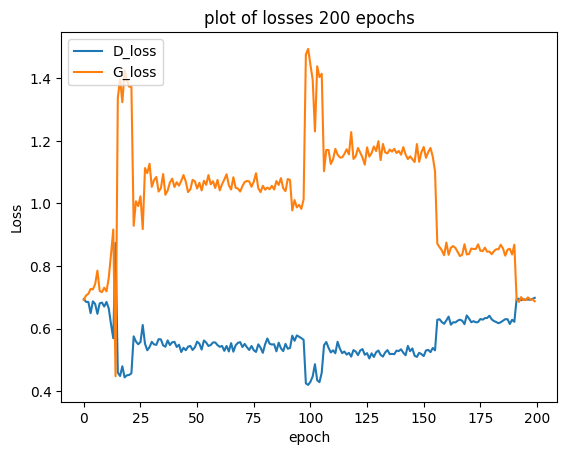

In [ ]:
# Plotting

plt.plot(history.history['loss_d'])
plt.plot(history.history['loss_g'])
plt.title('plot of losses '+str(N_epochs)+' epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['D_loss','G_loss'],loc='upper left')
plt.show()

